Trading prediction

Importuri necesare

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

Încărcarea dataset-ului
Încărcarea datelor:
• Se definește calea către fișierul CSV și se încarcă datele într-un DataFrame folosind pd.read_csv(), apoi se afișează numele coloanelor pentru a verifica structura datelor.

Conversia Timestamp în format datetime:
• Se utilizează pd.to_datetime() pentru a transforma valorile din coloana 'Timestamp' în obiecte de tip datetime, specificând unitatea 's' (secunde) și folosind errors='coerce' pentru a converti eventualele valori invalide în NaT (Not a Time).

Crearea unei coloane cu timestamp numeric:
• Se aplică o funcție lambda pe coloana 'Date' pentru a converti fiecare valoare datetime într-un timestamp numeric (numărul de secunde), păstrând np.nan pentru valorile lipsă, și se salvează rezultatul în coloana 'NumericTimestamp'.

Eliminarea coloanelor non-numerice și calculul corelației:
• Se elimină coloanele 'Date' și 'Timestamp' (care nu sunt numerice) folosind drop(), astfel încât să se păstreze doar coloanele numerice, iar apoi se calculează matricea de corelație între aceste coloane folosind corr().

Corelația Pearson:
• Măsoară relația liniară dintre două variabile. Valorile variază între –1 (corelație negativă perfectă) și +1 (corelație pozitivă perfectă).

In [3]:
file_path = "C:\\Users\\Marian.Pop\\Downloads\\btcusd_1-min_data.csv"
data = pd.read_csv(file_path)
print(data.columns)

# Convertește coloana 'Timestamp' în datetime (folosind errors='coerce' pentru a transforma valorile invalide în NaT)
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
# Tratarea valorilor lipsă fără a le elimina
data['NumericTimestamp'] = data['Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

# Elimină coloanele non-numerice pentru calculul corelațiilor
numeric_data = data.drop(columns=['Date', 'Timestamp'])
corr_matrix = numeric_data.corr()
print(numeric_data.corr())

print(corr_matrix['Close'].sort_values(ascending=False))

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                      Open      High       Low     Close    Volume  \
Open              1.000000  1.000000  1.000000  0.999999 -0.084553   
High              1.000000  1.000000  0.999999  1.000000 -0.084472   
Low               1.000000  0.999999  1.000000  1.000000 -0.084650   
Close             0.999999  1.000000  1.000000  1.000000 -0.084561   
Volume           -0.084553 -0.084472 -0.084650 -0.084561  1.000000   
NumericTimestamp  0.789259  0.789239  0.789282  0.789259 -0.079790   

                  NumericTimestamp  
Open                      0.789259  
High                      0.789239  
Low                       0.789282  
Close                     0.789259  
Volume                   -0.079790  
NumericTimestamp          1.000000  
Close               1.000000
High                1.000000
Low                 1.000000
Open                0.999999
NumericTimestamp    0.789259
Volume             -0.0845

 data.describe() calculează și afișează un rezumat statistic al coloanelor numerice din DataFrame, incluzând numărul de înregistrări (count), 
 media (mean), abaterea standard (std), valorile minime și maxime, precum și percentila 25%, 50% (mediană) și 75%.

In [4]:
data.describe()

,Timestamp,Open,High,Low,Close,Volume,Date,NumericTimestamp
count,6.781280e+06,6.781281e+06,6.781281e+06,6.781281e+06,6.781281e+06,6.781281e+06,6781280,6.781280e+06
mean,1.528948e+09,1.509086e+04,1.509729e+04,1.508421e+04,1.509087e+04,5.438073e+00,2018-06-14 03:39:19.117086720,1.528948e+09
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00,2012-01-01 10:01:00,1.325412e+09
25%,1.427142e+09,4.151000e+02,4.152100e+02,4.150000e+02,4.150900e+02,1.848367e-02,2015-03-23 20:20:45,1.427142e+09
50%,1.528872e+09,6.328000e+03,6.329980e+03,6.325810e+03,6.328000e+03,4.970804e-01,2018-06-13 06:40:30,1.528872e+09
75%,1.630602e+09,2.373600e+04,2.374400e+04,2.372700e+04,2.373570e+04,3.156358e+00,2021-09-02 17:00:15,1.630602e+09
max,1.741824e+09,1.089460e+05,1.090300e+05,1.087760e+05,1.089600e+05,5.853852e+03,2025-03-13 00:00:00,1.741824e+09
std,1.175994e+08,2.071437e+04,2.072215e+04,2.070639e+04,2.071439e+04,2.287123e+01,NaN,1.175994e+08


 data.head(50) returnează primele 50 de rânduri din DataFrame, oferind o previzualizare rapidă a datelor.

In [5]:
data.head(50)

,Timestamp,Open,High,Low,Close,Volume,Date,NumericTimestamp
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00,1.325412e+09
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00,1.325412e+09
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00,1.325412e+09
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00,1.325412e+09
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00,1.325412e+09
5,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:06:00,1.325412e+09
6,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:07:00,1.325412e+09
7,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:08:00,1.325412e+09
8,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:09:00,1.325413e+09
9,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:10:00,1.325413e+09


 data.columns = data.columns.str.capitalize() transformă numele coloanelor, punând prima literă a fiecărui nume cu majusculă și restul cu minuscule.

In [6]:
data.columns = data.columns.str.capitalize()
print(data.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Date',
       'Numerictimestamp'],
      dtype='object')


Conversia și sortarea datelor:
Se convertește coloana 'Date' în format datetime cu formatul '%Y-%m-%d %H:%M:%S' și se sortează DataFrame-ul în ordine cronologică.

Curățarea datelor:
Se elimină duplicatele și se filtrează rândurile cu volum zero pentru a asigura acuratețea analizei.

Resampling la date zilnice:
Se resamplează datele la nivel zilnic, agregând:

'Open' – prima valoare a zilei,
'High' – maximul zilei,
'Low' – minimul zilei,
'Close' – ultima valoare a zilei,
'Volume' – suma volumelor.

In [7]:
# Data Cleaning and Preprocessing
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

# Sort by Date
data.sort_values('Date', inplace=True)

# Handle zero volume rows (optional: drop or replace)
data = data[data['Volume'] > 0]

# Resample to daily data
daily_data = data.set_index('Date').resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

Se resamplează datele zilnice la nivel anual, selectând ultima valoare a fiecărui an pentru prețul de închidere, rezultând în DataFrame-ul annual_data.
Se configurează o figură de 14x7 inch și se plotează linia prețului de închidere anual în albastru.
Se adaugă titlul graficului, etichete pentru axele x și y, legendă și grilă, iar graficul este afișat.

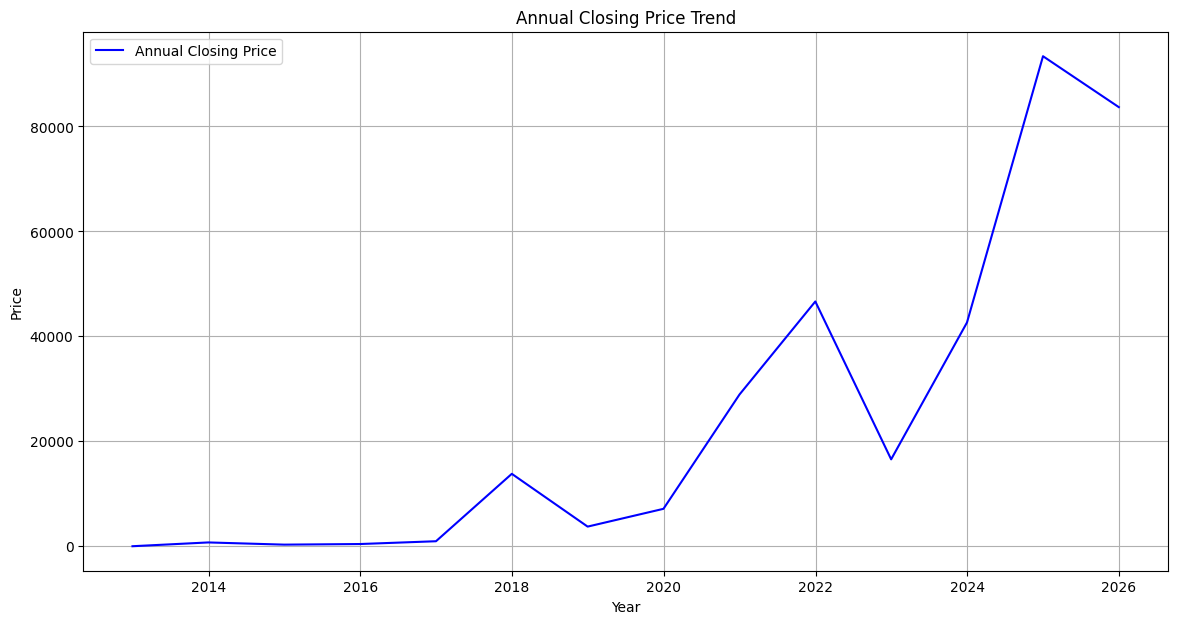

In [8]:
annual_data = daily_data.resample('YE').last()

plt.figure(figsize=(14, 7))
plt.plot(annual_data['Close'], label='Annual Closing Price', color='blue')
plt.title('Annual Closing Price Trend')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Se plotează valorile zilnice din coloana 'Volume' ca linie de culoare portocalie, etichetată "Daily Volume".
Se adaugă titlul "Daily Volume Trend" și se etichetează axele (x: "Date", y: "Volume").
Se afișează legenda și grila, iar graficul este redat.

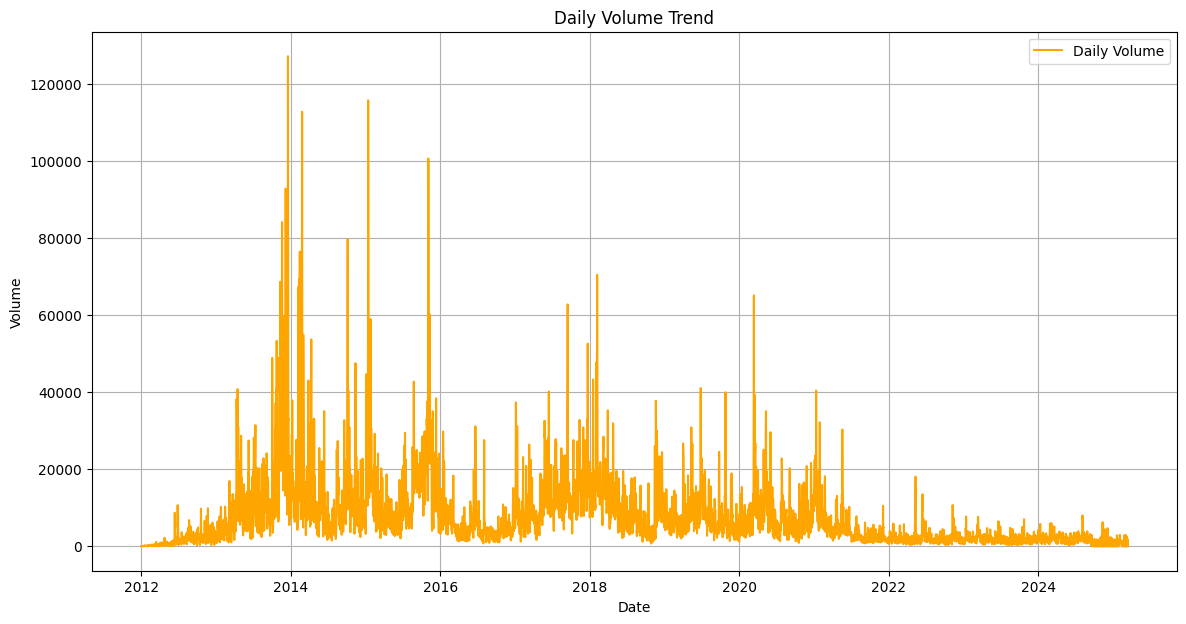

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Volume'], label='Daily Volume', color='orange')
plt.title('Daily Volume Trend')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

Decompoziţia sezonieră (additivă) împarte seria “Close” în patru componente distincte:

Trend: evoluția pe termen lung — arată direcția generală (creștere, scădere sau stagnare) eliminând variațiile pe termen scurt.

Sezonal: fluctuațiile repetitive care se reiau anual (periodicitate de 365 de zile). Aceasta evidenţiază modele precum creșteri sau scăderi recurente în anumite luni/sezoane.

Rezidual: componenta „rest” — variația neexplicată de trend şi sezonalitate (zgomotul, evenimentele neașteptate sau factori necapturați de model).

Se generează un grafic cu subgrafice pentru componentele: Observat, Trend, Sezonal și Rezidual, care evidențiază diferitele aspecte ale seriei temporale.
Se afișează graficul rezultant.
Datele curățate și resample-ate sunt salvate într-un fișier CSV intitulat "btcusd_1-min_data.csv".
Se afișează un mesaj de confirmare că datele au fost curățate, resample-ate și vizualizate cu succes.

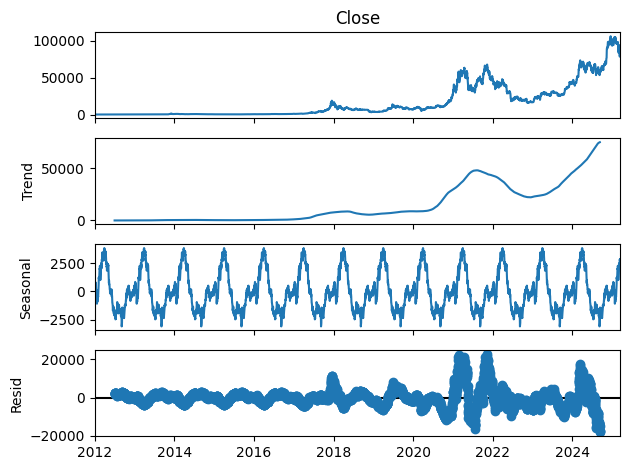

Data cleaned, resampled, and visualized. Saved as 'btcusd_1-min_data.csv'.


In [10]:
decompose_result = seasonal_decompose(daily_data['Close'], model='additive', period=365)

decompose_result.plot()
plt.show()

# Save cleaned and resampled data
daily_data.to_csv('btcusd_1-min_data.csv')

print("Data cleaned, resampled, and visualized. Saved as 'btcusd_1-min_data.csv'.")

Gini index (Close price): 0.9567
Entropy (Close price): 6.5759 bits


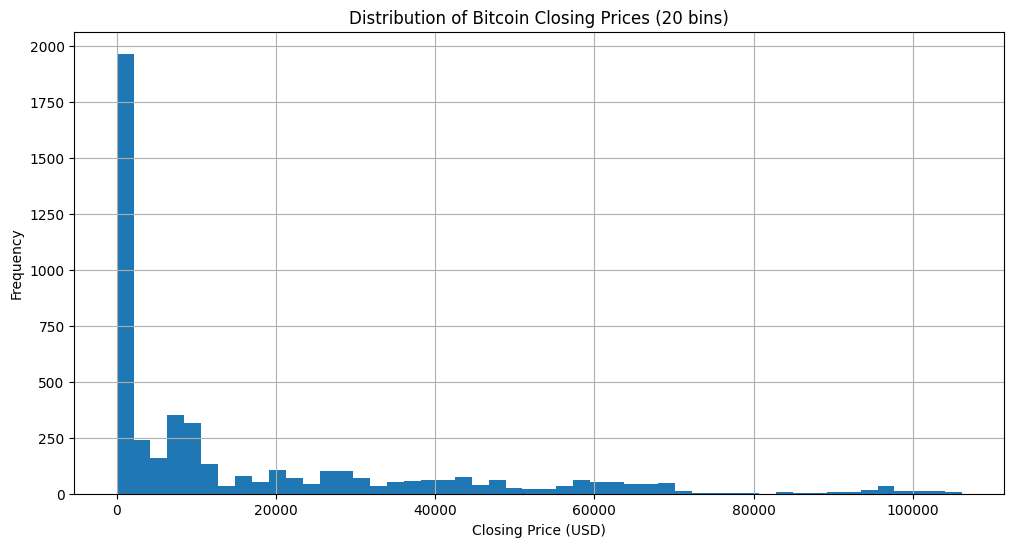

In [ ]:
# Extragem seria de prețuri de închidere
values = daily_data['Close'].dropna()

# Discretizare în 50 de bin-uri (puteți ajusta)
counts, _ = np.histogram(values, bins=500)

# Probabilități 
probs = counts[counts>0] / counts.sum()

# Calculul entropiei
entropy = -np.sum(probs * np.log2(probs))
gini_index = 1 - np.sum(probs**2)
print(f"Gini index (Close price): {gini_index:.4f}")

print(f"Entropy (Close price): {entropy:.4f} bits")


plt.figure(figsize=(12, 6))
plt.hist(daily_data['Close'].dropna(), bins=50)
plt.title('Distribution of Bitcoin Closing Prices (50 bins)')
plt.xlabel('Closing Price (USD)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Indicele Hurst

Măsoară persistența (memoria) unei serii temporale.

Interpretare:
H>0.5: Seria este persistentă (tendința de a continua în aceeaşi direcţie).

H<0.5: Seria este anti-persistentă (tendinţa de inversare a trendului).

H=0.5: Seria se comportă ca un proces aleator (random walk).

In [ ]:
import numpy as np

def hurst_exponent(ts):
    """Calculează indicele Hurst pentru o serie temporală ts."""
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

close_prices = daily_data['Close'].dropna().values 
hurst = hurst_exponent(close_prices)
print(f"Indicele Hurst: {hurst:.4f}")


Indicele Hurst: 1.0954


Beta
Măsoară sensibilitatea activului față de mișcările unui indice de referință sau a pieței.

Interpretare:
Beta > 1: Activul este mai volatil decât piața.
Beta < 1: Activul este mai puțin volatil.
Beta = 1: Activul are volatilitate similară cu piața.

Pentru a calcula Beta, avem nevoie de serii temporale pentru prețul activului și pentru indicele de referință.
Beta = Cov(Ra, Rm) / Var(Rm)  
unde:  
- Ra = randamentul activului  
- Rm = randamentul pieței  
- Cov(Ra, Rm) = covarianța dintre randamentul activului și randamentul pieței  
- Var(Rm) = varianța randamentului pieței

O valoare Beta (0.5768) se interpretează astfel:

Subunitar: Deoarece Beta este mai mic decât 1, indică faptul că activul (Bitcoin) este mai puțin volatil decât indicele de referință.

Sensibilitate redusă: Dacă piaţa de referinţă se modifică cu 1% într-o anumită direcţie, preţul Bitcoin, conform modelului, se modifică în medie cu aproximativ 0.5768% în aceeaşi direcţie.

Risc sistematic mai scăzut: În contextul managementului riscului, un Beta sub 1 sugerează că activul are o expunere mai mică la mişcările pieţei, ceea ce poate fi interpretat ca un risc sistematic mai redus în comparaţie cu piaţa ca întreg.

In [ ]:
import yfinance as yf


# Descărcăm date pentru un indice de piață, de exemplu S&P 500 (simbol: ^GSPC)
market_data = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')

# Vom folosi prețul de închidere al indicele de piață
market_data = market_data[['Close']].rename(columns={'Close': 'Market_Close'})

print(market_data.head())
# Calculăm randamentele zilnice
daily_returns = daily_data['Close'].pct_change().dropna()
market_returns = market_data['Market_Close'].pct_change().dropna()

# Aliniem datele: presupunem că indexul lor este datetime și facem inner join
returns = pd.concat([daily_returns, market_returns], axis=1, join='inner')
returns.columns = ['Asset', 'Market']

# Calculăm Beta:
covariance = np.cov(returns['Asset'], returns['Market'])[0,1]
market_variance = np.var(returns['Market'])
beta = covariance / market_variance

print(f"Beta: {beta:.4f}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price      Market_Close
Ticker            ^GSPC
Date                   
2012-01-03  1277.060059
2012-01-04  1277.300049
2012-01-05  1281.060059
2012-01-06  1277.810059
2012-01-09  1280.699951
Beta: 0.5768
